# Preparing Dataset

Author: Alex Lim

This notebook presents a class that handles preparing the dataset into a standardized format that is recognized for the image dataset pipeline. Expects to take as input a data path of folders of images where each folder name is a unique class and the images within the folder are the corresponding class instances. 

## Module Imports

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import math
import time
import random
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

# Set random seed for consistency
random.seed(100) 

# Displays all outputs of a cell (not just last output)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 5]

## Define Dataset Directories

We expect the dataset to be in a `Data` directory containing several folders of images where the name of the folder corresponds to the unique data `Class` that we are interested in. For example, this project consists of three unique classes of grape diseases and one negative class for healthy leaves: `Black Measles`, `Black Rot`, `Leaf Blight`, and `Healthy`.

Example of data directory file structure.
```
${DISEASE_ROOT}
|--data
   |-- black_measles
   |   |-- black_measles0.jpg
   |   |-- black_measles1.jpg
   |   |-- ...
   |-- black_rot
   |   |-- black_rot0.jpg
   |   |-- black_rot1.jpg
   |   |-- ...
   |-- healthy
   |   |-- healthy0.jpg
   |   |-- healthy1.jpg
   |   |-- ...
   |-- leaf_blight
   |   |-- leaf_blight0.jpg
   |   |-- leaf_blight1.jpg
   |   |-- ...
```

The below class helps prepare the dataset provided by a user to split it into train/validation/test in the proper format required to feed into a Keras ImageDataGenerator pipeline.

In [3]:
class DatasetPreparer:
    """Class to prepare data and split into train/val/test
    in a format which is compatible with Keras. Expects data
    directory structure where folders represent unique class
    names and contains corresponding class images.
    """
    def __init__(self, datapath):
        self.datapath = datapath
        self.classes = None
        self.total_images = None
        self.num_instances = OrderedDict()
        self.num_train = OrderedDict()
        self.num_val = OrderedDict()
        self.num_test = OrderedDict()
        self.load_data()

    def load_data(self):
        """Gets all valid classes from data folder. Expects
        each folder to contain image files pertaining to
        the class that the folder represents.
        """
        content = os.listdir(self.datapath)
        classes = []
        total_images = 0

        # Check that each dir contains only images
        for directory in content:
            if self.verify_class(directory) is True:
                classes.append(directory)
                num_images = len(
                    os.listdir(os.path.join(self.datapath, directory)))
                self.num_instances[directory] = num_images
                total_images += num_images

        self.classes = classes
        self.total_images = total_images

    def verify_class(self, directory):
        """Verifies that class directory contains
        all images only. Only supports JPG and PNG
        images.
        """
        valid_image_ext = ['.jpg', '.jpeg', '.png']
        files = os.listdir(os.path.join(self.datapath, directory))

        if len(files) > 0:
            for file in files:
                _, ext = os.path.splitext(file)
                if ext not in valid_image_ext:
                    return False
            return True
        else:
            return False

    def rename_images(self):
        """Helper function to rename all images inside a directory to
        a standard naming scheme.
        """
        for label in self.classes:
            path = os.path.join(self.datapath, label)
            for i, image in enumerate(os.listdir(path)):
                _, ext = os.path.splitext(image)
                new_name = label + str(i) + ext
                src = os.path.join(path, image)
                dst = os.path.join(path, new_name)
                os.rename(src, dst)
            print('Finished renaming images for class {}'.format(label))

    def split_train_test_val(self, test_size=0.2, stratified=True):
        """Splits each valid folder of class images into
        train/val/test directories.2
        """
        train_dir = os.path.join(self.datapath, 'train')
        validation_dir = os.path.join(self.datapath, 'validation')
        test_dir = os.path.join(self.datapath, 'test')

        # Make directories for train/val/test
        for item in ['train', 'validation', 'test']:
            os.makedirs(os.path.join(self.datapath, item), exist_ok=True)

        # Split train/val/test for each class
        for label in self.classes:
            data_path = os.path.join(self.datapath, label)
            num_examples = len(os.listdir(data_path))

            # Make the directories
            for directory in [train_dir, validation_dir, test_dir]:
                os.makedirs(os.path.join(directory, label), exist_ok=True)

            assert len(os.listdir(os.path.join(train_dir, label))) == 0, \
                'Train directory for {} is not empty.'.format(label)
            assert len(os.listdir(os.path.join(validation_dir, label))) == 0, \
                'Validation directory for {} is not empty'.format(label)
            assert len(os.listdir(os.path.join(test_dir, label))) == 0, \
                'Test directory for {} is not empty.'.format(label)

            # Shuffle the data
            datafiles = os.listdir(data_path)
            random.shuffle(datafiles)

            # Train-test split
            num_test = math.floor(num_examples*0.2)
            num_train = num_examples - num_test

            # Train-validation split
            num_val = math.floor(num_train*0.2)
            num_train = num_train - num_val

            # Train, validation, and test data
            train_files = datafiles[:num_train]
            val_files = datafiles[num_train:num_train+num_val]
            test_files = datafiles[num_train+num_val:]

            # Copy training data
            train_dir_class = os.path.join(train_dir, label)
            for filename in train_files:
                src = os.path.join(data_path, filename)
                dst = os.path.join(train_dir_class, filename)
                shutil.copyfile(src, dst)

            # Copy validation data
            val_dir_class = os.path.join(validation_dir, label)
            for filename in val_files:
                src = os.path.join(data_path, filename)
                dst = os.path.join(val_dir_class, filename)
                shutil.copyfile(src, dst)

            # Copy test data
            test_dir_class = os.path.join(test_dir, label)
            for filename in test_files:
                src = os.path.join(data_path, filename)
                dst = os.path.join(test_dir_class, filename)
                shutil.copyfile(src, dst)

            # Store number of instances
            self.num_train[label] = len(os.listdir(train_dir_class))
            self.num_val[label] = len(os.listdir(val_dir_class))
            self.num_test[label] = len(os.listdir(test_dir_class))

            print('Completed train/val/test split for class {}'.format(label))

## Construct Dataset

In [4]:
ROOT_DIR = '.'
DATA_DIR = os.path.join(ROOT_DIR, 'data')

dataset = DatasetPreparer(DATA_DIR)

### Observe Number of Images Per Class

In [5]:
num_images = dataset.num_instances.items()

print('Total Images: ', dataset.total_images)
for item in num_images:
    print('{} class has {} images.'.format(item[0], item[1]))

Total Images:  4062
black_rot class has 1180 images.
black_measles class has 1383 images.
healthy class has 423 images.
leaf_blight class has 1076 images.


### Observe Distribution of Class Instances

In [6]:
total_images = dataset.total_images

for item in num_images:
    pct = (item[1] / total_images) * 100.0
    print('Percentage of {} class: {:.2f}%'.format(item[0], pct))

Percentage of black_rot class: 29.05%
Percentage of black_measles class: 34.05%
Percentage of healthy class: 10.41%
Percentage of leaf_blight class: 26.49%


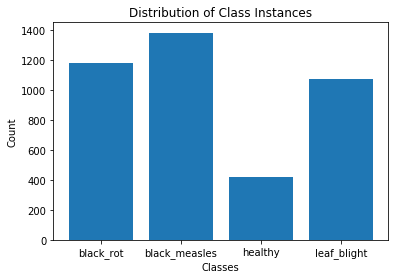

In [7]:
data = dataset.num_instances

plt.bar(range(len(data)), data.values(), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of Class Instances')
plt.show();

It is observed that this dataset has a fair amount of imbalance (especially in the case of healthy class). Therefore, this projects included further considerations for performance metrics and handling of this imbalance.

### Rename Image Files

We want to standardize the naming scheme of the images belonging to a unique class. Therefore, the DataPreparer class has a method which renames all images to a standard form. 

In [8]:
# Only run once, no need to run again if already renamed
#dataset.rename_images()

### Shuffle and Train-Validation-Test Split

We will not split our dataset into train, validation, and test sets. First we will randomize the images and apply a stratified split to consider the distribution of the dataset. 

We will allocate 80% for training and 20% for test. Then we will split the training set into 80% training and 20% validation.

The dataset directory tree must follow a specific format for Keras to be able to correctly construct the data pipeline. The format is shown in the image below:

![image](https://cdn-images-1.medium.com/max/800/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)

In [9]:
# Only run once, no need to run again if already split
#dataset.split_train_test_val()

Run a sanity check to see that data distribution between train/validation/test is consistent.

In [10]:
ROOT_DIR = '.'
DATA_DIR = os.path.join(ROOT_DIR, 'data')

# Total dataset
print('Total Images: ', dataset.total_images)
for item in num_images:
    print('{} class has {} images.'.format(item[0], item[1]))
print()
for item in dataset.num_train.items():
    print('Number of {} train images: {}'.format(item[0], item[1]))
print()    
for item in dataset.num_val.items():
    print('Number of {} validation images: {}'.format(item[0], item[1]))
print()
for item in dataset.num_test.items():
    print('Number of {} test images: {}'.format(item[0], item[1]))
print()
for item in dataset.num_instances.items():
    pct = (item[1] / dataset.total_images) * 100.0
    print('Percentage of {} class: {:.2f}%'.format(item[0], pct))
print()
for item in dataset.num_train.items():
    pct = item[1]/sum(dataset.num_train.values())*100.0
    print('Percentage of train {} class: {:.2f}%'.format(item[0], pct))
print()
for item in dataset.num_val.items():
    pct = item[1]/sum(dataset.num_val.values())*100.0
    print('Percentage of validation {} class: {:.2f}%'.format(item[0], pct))
print()
for item in dataset.num_test.items():
    pct = item[1]/sum(dataset.num_test.values())*100.0
    print('Percentage of test {} class: {:.2f}%'.format(item[0], pct))

Total Images:  4062
black_rot class has 1180 images.
black_measles class has 1383 images.
healthy class has 423 images.
leaf_blight class has 1076 images.




Percentage of black_rot class: 29.05%
Percentage of black_measles class: 34.05%
Percentage of healthy class: 10.41%
Percentage of leaf_blight class: 26.49%



